In [1]:
import re
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects
from Models.Caller import *
from BatchMIEvaluation import LoadModelConfigs, LoadParams
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

In [4]:
YamlPath = './Config/EvalConfigII800.yml'
ConfigName = 'SKZFC_II_50_800'

EvalConfigs = ReadYaml(YamlPath)
ModelConfigs = ReadYaml(YamlPath)
NJ = 1

# Loading the model configurations
ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']


# Object Load path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'_Nj'+str(NJ)+'.pkl'

# Loading data
AnalData = np.load('./Data/ProcessedData/Val'+str(Params['SigType'])+'.npy')

# Intermediate parameters 
SigDim = AnalData.shape[1]
DataSize = AnalData.shape[0]

In [5]:
# Calling Modesl
SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)

# Setting Model Specifications and Sub-models
if Params['LossType'] =='Default':
    EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
elif Params['LossType'] =='FACLosses':
    EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts

    
## The generation model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

## The sampling model for evaluation
Zs_Out = SigRepModel.get_layer('Zs').output
SampModel = Model(EncModel.input, Zs_Out)



OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_7 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_18 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_7[0][0]']      
 l)                                                                                               
                                                                                                  
 b

4/4 [==============================] - 1s 3ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_20448\2916679034.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


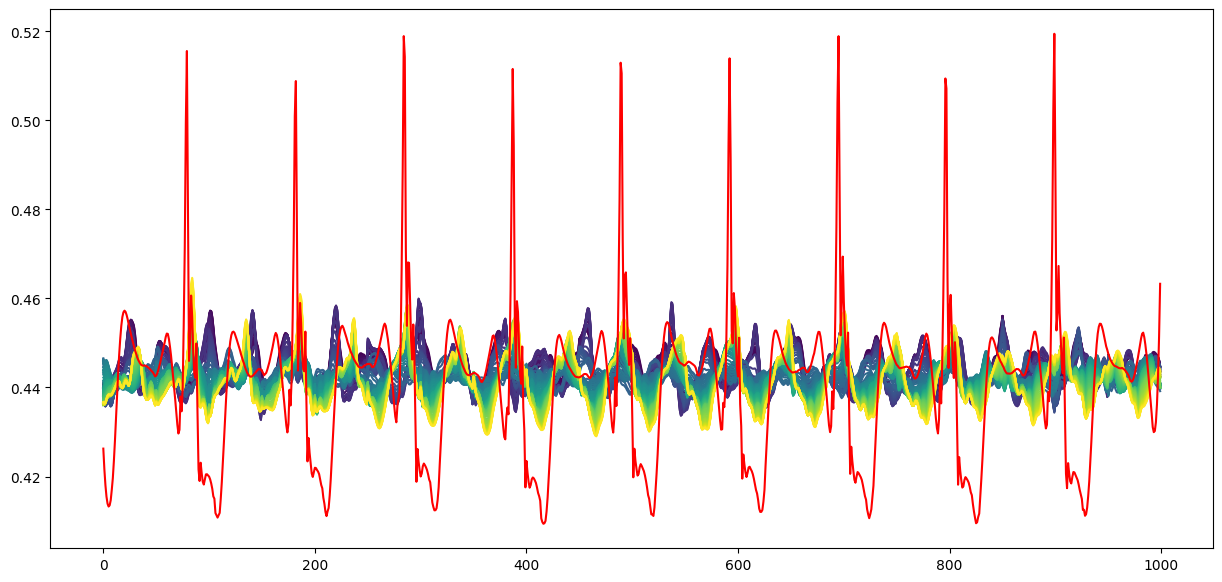

In [6]:
SelIDX= 600
N_Gen = 100
MinFreqR=0.0
MaxFreqR=0.06

InpSignal = np.repeat(AnalData[SelIDX:SelIDX+1], N_Gen, axis=0)
PredZs = SampModel.predict(InpSignal)


FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,4))

FeatGen = FeatGenModel([FC_Comm,FC_Each, PredZs])

PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
ReconSignal = ReconModel([FeatGen])

# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Gen-1)

fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Gen):
    color = cmap(norm(i))
    ax.plot(ReconSignal[i], color=color)
plt.plot(InpSignal[0], color='red')

#### Selecting post Samp_Zj for generating plausible signals

In [8]:
# When you want to restore those objects
# Create a new instance
NewEval = Evaluator()
# Populate it with the saved data
DeserializeObjects(NewEval, ObjLoadPath)

# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = NewEval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 32102


#### Post EvalKld_TrueGen

4/4 [==============================] - 7s 666ms/step
KldPSD_GenTrue:  0.08988798002251824
KldPSD_TrueGen:  0.12400734721080321
MeanKld_GTTG:  0.10694766361666072


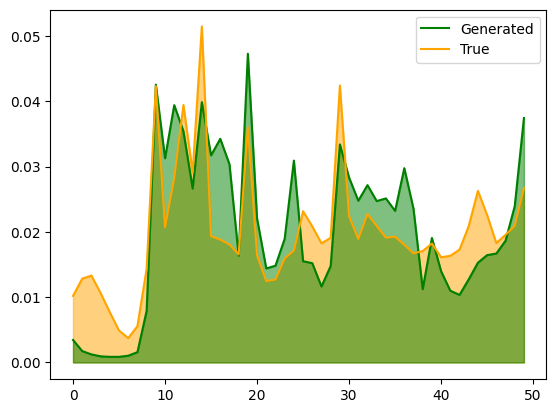

In [10]:
NewEval.GenModel = GenModel
NewEval.KLD_TrueGen(AnalSig=AnalData[:]) 

### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [9]:
TrackerCandZ = NewEval.TrackerCand
BestZsMetrics = NewEval.BestZsMetrics
NewEval.CandFreqIDs
LatDim = 30

#### Visualization of signals given Z values

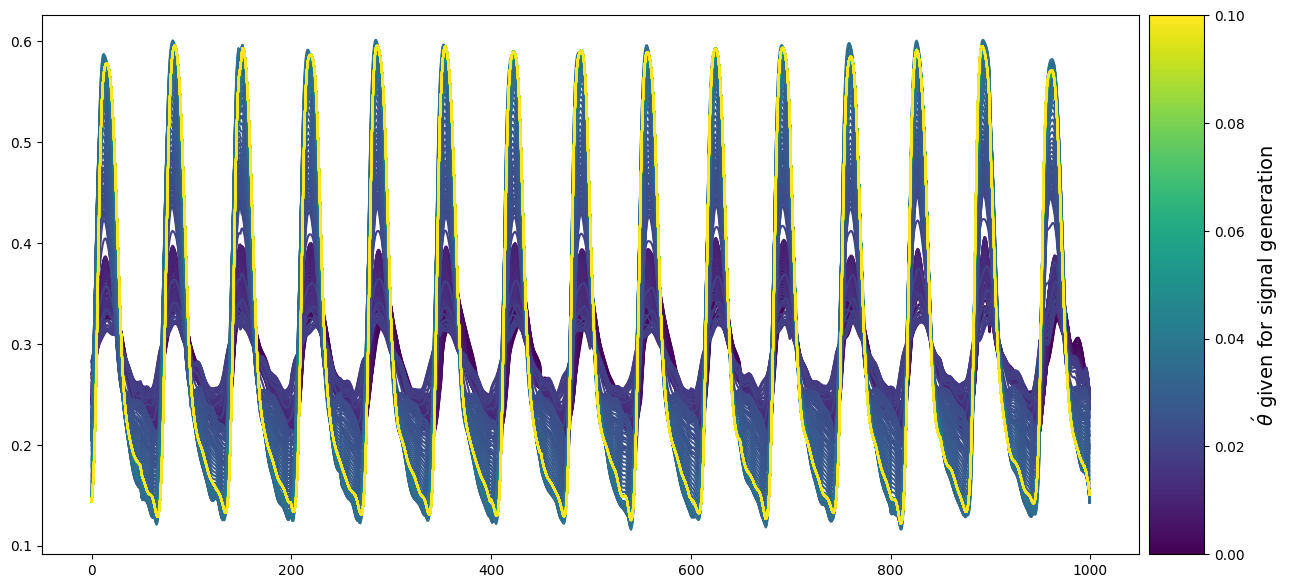

In [10]:
FreqID = 15
ZFixSubID = 1
SelZ =  NewEval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(NewEval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NewEval.PostSamp[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel,  SelZ, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.1)

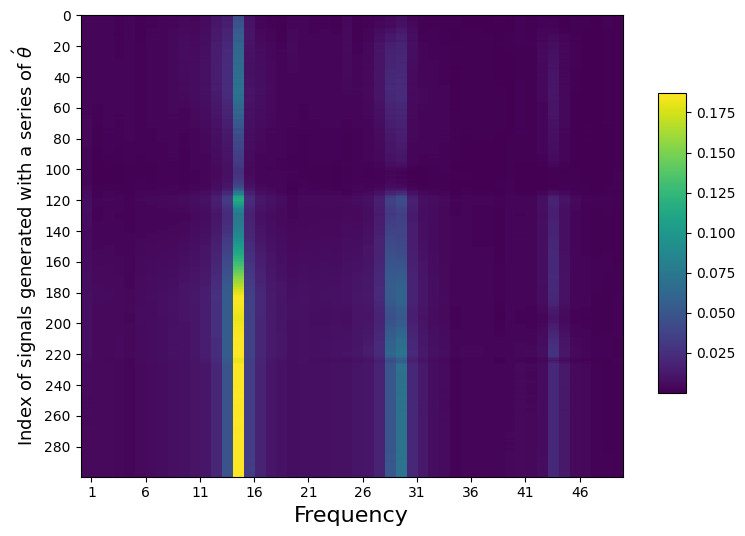

In [9]:
HeatMapFreqZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, N_Gen=300)

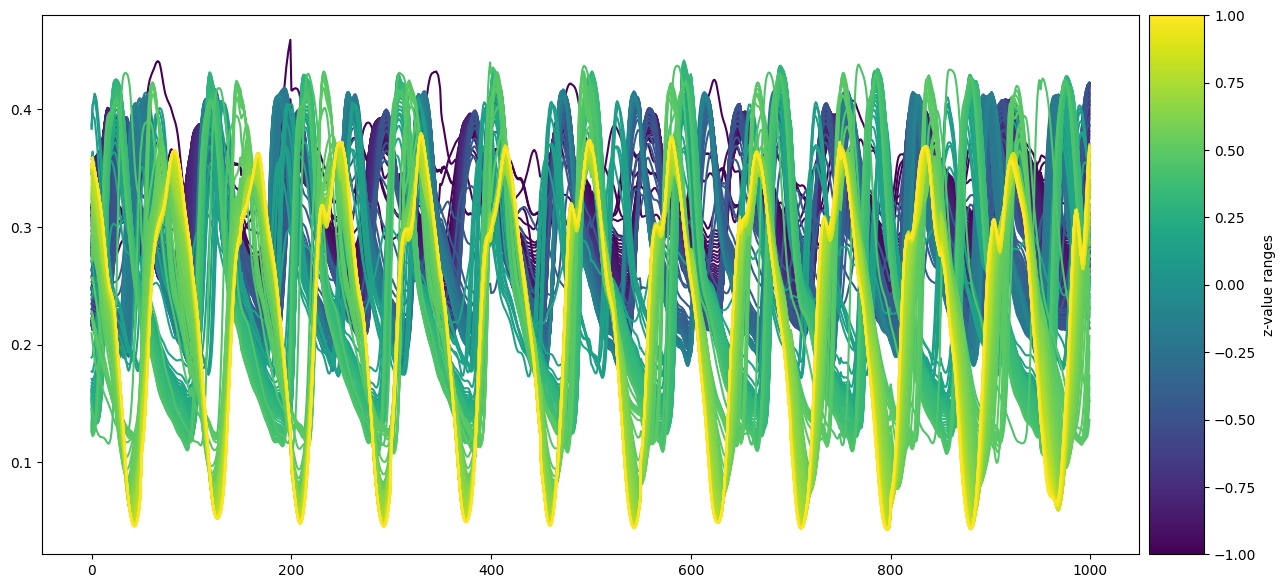

In [20]:
FcCommFix = {0: 0.05, 1: 0.05}
FcEachFix  = {0: 0.05, 1: 0.05, 2: 0.05, 3: 0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFC_ZA (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=300, MinZval = -1., MaxZval = 1., CutLower=-0.1, CutUpper = 0.1)

(100, 1000)


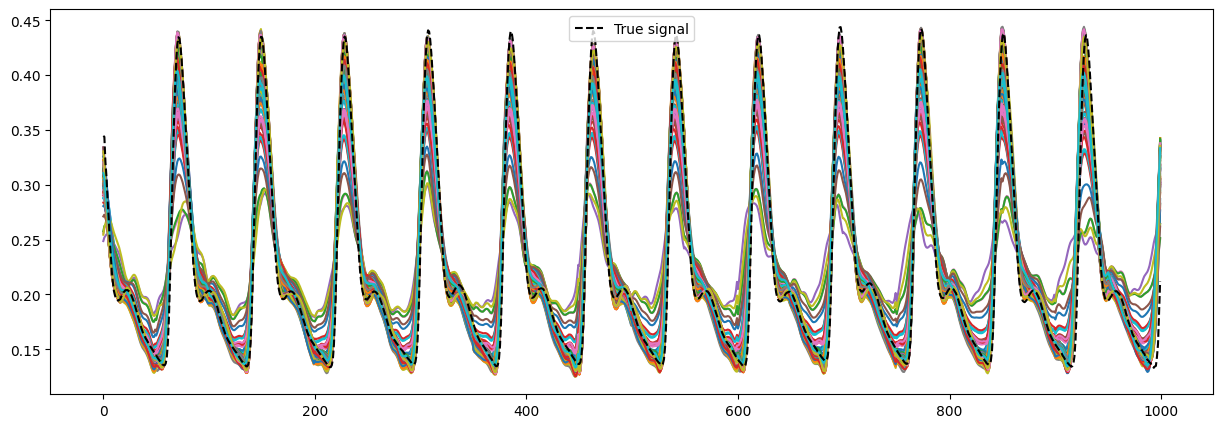

In [19]:
idx = 9871

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtractZ_FC (AnalData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)

In [15]:
# Power spectral density 
def FFT_PSD (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (N, M, N_frequency)
    PSD = (FFTRes**2)/Data.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis =='Sample':
        AggPSD = np.mean(PSD, axis=(1))
        # (NMiniBat, N_frequency)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis == 'None':
        # (NMiniBat, NGen, N_frequency)
        AggPSPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSPDF

In [24]:
FFTRES_Anal = FFT_PSD(AnalData, ReducedAxis='Sample')
FFTRES_Anal_MaxFreqID = np.argmax(FFTRES_Anal, axis=-1)

In [26]:
np.where(FFTRES_Anal_MaxFreqID < 8)

(array([   44,    68,    73, ..., 59942, 59966, 59990], dtype=int64),)

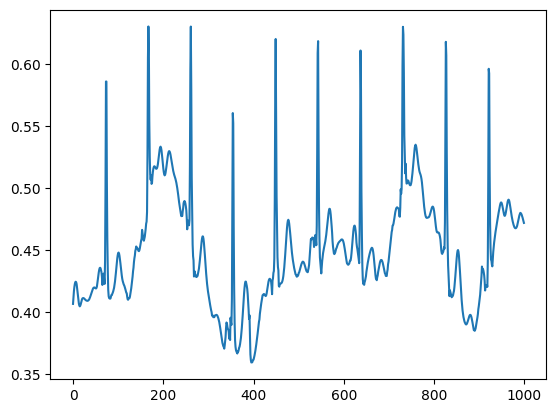

In [27]:
plt.plot(AnalData[44])